<a href="https://colab.research.google.com/github/jvmorenot1/Taller_3/blob/main/Taller_3_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taller 3- Ciencia de datos aplicada**
# **Modelos de clasificación y API REST**

### **Integrantes**
*   Yachay Tolosa Bello – 202315750
*   Kevin Infante Hernández – 201117324​
*   John Vicente Moreno Triviño – 202210162

### **Objetivo de negocio**
*   Aplicar Machine Learning para predecir los usuarios que cancelarán sus servicios en una empresa de telecomunicaciones, habilitando así al Área de Mercadeo para generar estrategias de retención enfocadas en los usuarios que se irían, partiendo de una caracterización de sus perfiles.

### **Objetivos tecnológicos**
*   Desarrollar dos modelos de clasificación que permitan predecir los usuarios que cancelarán sus servicios. Uno será un modelo base, mientras que el otro será un modelo más refinado.
*   Desplegar una API REST para operacionalizar estos modelos y que puedan ser usados por la empresa.
*   Realizar un proceso de A/B Testing que permita comparar el rendimiento semanal de los dos modelos desarrollados.

**Dataset:** registros con datos de los clientes e información sobre si han cancelado el servicio o no.

[[histórico](https://drive.google.com/file/d/1mR7emXc8oTNG4WL-KvcWMLip2A1RdmMB/view?usp=sharing)]

[[futuros](https://drive.google.com/file/d/16C7_j-AhBZ3k2uH9FOfnSPiXDbGhelAK/view?usp=sharing)]


# **0. Instalación e importación de librerias**

In [2]:
!pip install --upgrade geopandas holidays pandas scikit-learn numpy pycaret xgboost seaborn shap ydata_profiling associations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [1]:
from joblib import dump

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp, chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import shap

import ydata_profiling

# Configuración de pandas para expandir el número de filas y columnas por defecto a mostrar
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Cambiar el formato en el que se muestran los valores float
pd.set_option("display.float_format", lambda x: "%.5f" % x)

from pycaret.classification import ClassificationExperiment, setup
from pycaret.classification import ClassificationExperiment

import transformersMethods

# **1. Entendimiento de los datos**

### **1.1 Exploración de los datos**

In [2]:
churn_hist_df = pd.read_json("/content/drive/MyDrive/churn_historic.json", orient='columns')
churn_fut_df = pd.read_json("/content/drive/MyDrive/churn_future.json", orient='columns')

In [3]:
print(churn_hist_df.shape)
print(churn_fut_df.shape)

(6000, 21)
(1000, 21)


In [ ]:
churn_hist_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Aquí solamente habría que decir que la variable "TotalCharges" es de tipo Float, pero dtypes la detecta como un objeto de texto puesto que tiene algunos campos que aparecen como cadenas de texto vacías "". Al momento de procesar los datos, esta variable será tratada como numérica. Así mismo, "SeniorCitizen" será tratada como una variable booleana catégorica (aunque aquí aparece como numérica por tratarse de 1's y 0's).

En general, todas las variables se podrán tratar como categóricas, excepto las que son evidentemente numéricas: "tenure", "MonthlyCharges" y "TotalCharges"; además de "customerID" que es una cadena de texto con el ID interno de cada cliente.

In [ ]:
churn_fut_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
churn_hist_df.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  5386-THSLQ  Female              1     Yes         No      66           No   
4  3192-NQECA    Male              0     Yes         No      68          Yes   
5  6180-YBIQI    Male              0      No         No       5           No   
6  6728-DKUCO  Female              0     Yes        Yes      72          Yes   
7  9750-BOOHV  Female              0      No         No      32           No   
8  8597-CWYHH    Male              0      No         No      43          Yes   
9  2848-YXSMW    Male              0     Yes        Yes      72          Yes   

      MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
0  No phone service             DSL                   No                  Yes   
1                No             DSL                  Yes                   No   
2                No             DSL                  Yes                  Yes   
3  No phone service             DSL                   No                  Yes   
4               Yes     Fiber optic                   No                  Yes   
5  No phone service             DSL                   No                   No   
6               Yes     Fiber optic                  Yes                  Yes   
7  No phone service             DSL                  Yes                   No   
8               Yes     Fiber optic                   No                   No   
9                No              No  No internet service  No internet service   

      DeviceProtection          TechSupport          StreamingTV  \
0                   No                   No                   No   
1                  Yes                   No                   No   
2                   No                   No                   No   
3                  Yes                   No                  Yes   
4                  Yes                  Yes                  Yes   
5                   No                   No                   No   
6                   No                   No                  Yes   
7                   No                   No                   No   
8                   No                   No                  Yes   
9  No internet service  No internet service  No internet service   

       StreamingMovies        Contract PaperlessBilling  \
0                   No  Month-to-month              Yes   
1                   No        One year               No   
2                   No  Month-to-month              Yes   
3                   No        One year               No   
4                  Yes        Two year              Yes   
5                   No  Month-to-month               No   
6                  Yes        One year              Yes   
7                   No        One year               No   
8                  Yes        One year               No   
9  No internet service        Two year               No   

               PaymentMethod  MonthlyCharges TotalCharges Churn  
0           Electronic check        29.85000     29.85000    No  
1               Mailed check        56.95000   1889.50000    No  
2               Mailed check        53.85000    108.15000   Yes  
3  Bank transfer (automatic)        45.55000   3027.25000    No  
4  Bank transfer (automatic)       110.00000   7611.85000   Yes  
5               Mailed check        24.30000    100.20000    No  
6           Electronic check       104.15000   7303.05000    No  
7               Mailed check        30.15000    927.65000    No  
8               Mailed check        94.35000   3921.30000    No  
9    Credit card (automatic)        19.40000   1363.25000    No

In [ ]:
churn_fut_df.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7795-CFOCW    Male              0      No         No      45           No   
1  9237-HQITU  Female              0      No         No       2          Yes   
2  9305-CDSKC  Female              0      No         No       8          Yes   
3  1452-KIOVK    Male              0      No        Yes      22          Yes   
4  6713-OKOMC  Female              0      No         No      10           No   
5  7892-POOKP  Female              0     Yes         No      28          Yes   
6  6388-TABGU    Male              0      No        Yes      62          Yes   
7  9763-GRSKD    Male              0     Yes        Yes      13          Yes   
8  7469-LKBCI    Male              0      No         No      16          Yes   
9  8091-TTVAX    Male              0     Yes         No      58          Yes   

      MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
0  No phone service             DSL                  Yes                   No   
1                No     Fiber optic                   No                   No   
2               Yes     Fiber optic                   No                   No   
3               Yes     Fiber optic                   No                  Yes   
4  No phone service             DSL                  Yes                   No   
5               Yes     Fiber optic                   No                   No   
6                No             DSL                  Yes                  Yes   
7                No             DSL                  Yes                   No   
8                No              No  No internet service  No internet service   
9               Yes     Fiber optic                   No                   No   

      DeviceProtection          TechSupport          StreamingTV  \
0                  Yes                  Yes                   No   
1                   No                   No                   No   
2                  Yes                   No                  Yes   
3                   No                   No                  Yes   
4                   No                   No                   No   
5                  Yes                  Yes                  Yes   
6                   No                   No                   No   
7                   No                   No                   No   
8  No internet service  No internet service  No internet service   
9                  Yes                   No                  Yes   

       StreamingMovies        Contract PaperlessBilling  \
0                   No        One year               No   
1                   No  Month-to-month              Yes   
2                  Yes  Month-to-month              Yes   
3                   No  Month-to-month              Yes   
4                   No  Month-to-month               No   
5                  Yes  Month-to-month              Yes   
6                   No        One year               No   
7                   No  Month-to-month              Yes   
8  No internet service        Two year               No   
9                  Yes        One year               No   

               PaymentMethod  MonthlyCharges TotalCharges Churn  
0  Bank transfer (automatic)        42.30000   1840.75000    No  
1           Electronic check        70.70000    151.65000   Yes  
2           Electronic check        99.65000    820.50000   Yes  
3    Credit card (automatic)        89.10000   1949.40000    No  
4               Mailed check        29.75000    301.90000    No  
5           Electronic check       104.80000   3046.05000   Yes  
6  Bank transfer (automatic)        56.15000   3487.95000    No  
7               Mailed check        49.95000    587.45000    No  
8    Credit card (automatic)        18.95000    326.80000    No  
9    Credit card (automatic)       100.35000   5681.10000    No

### **1.2 Análisis univariado - Calidad de los datos**

Primero que todo, se aclara que no se hablará aquí de los datos futuros, porque para efectos del ejercicio, se supone que estos datos aún no los tenemos al momento de desarrollar el modelo.

Ahora, utilizando la herramienta ydata_profiling, se darán unos breves insights sobre los datos históricos y su calidad a nivel univariado:

*   **Precisión:** validar esta dimensión de la calidad de los datos está fuera del alcance de este ejercicio, puesto que no se tiene información de cómo se ha construido este dataset en la empresa de telecomunicaciones del caso. Sin embargo, en general es posible observar que las variables tienen valores lógicos:

  *   La distribución entre hombres y mujeres es más o menos pareja.
  *   Los ID de los clientes son todos diferentes.
  *   El tiempo de permanencia de los usuarios muestra una distribución coherente, aunque se presenta un pico algo sospechoso de usuarios que tienen 70 o más semanas de afiliación. En la práctica real, la precisión de este dato debería validarse con los responsables de negocio, pero para este ejercicio se asumirá que se trata de clientes de larga data y alta fidelidad (No han cancelado).
  *   La mayoría de los usuarios han contratado servicio de teléfono y también de Internet.
  *   Solamente entre una cuarta y una tercera parte del total de los usuarios ha contratado servicios adicionales, tales como seguridad online, backups, protección de dispositivos o servicios de streaming (TV y/o Películas).
  *   Predominan los contratos mensuales y son más los usuarios que prefieren recibir sus cuentas sin papel de por medio.
  *   Predominan los métodos eléctronicos de pago, incluyendo aquí las tarjetas de crédito y las transferencis bancarias.
  *   Y los pagos mensuales van desde los USD 18 hasta USD 119, lo cual es coherente con los precios que se suele pagar en un país como USA por el servicio de Internet y/o teléfono. Además, resulta normal que exista un pico de usuarios que apenas paga entre 18 y 20 USD por mes, ya que son aquellos que han elegido un plan económico con solo servicio de telefonía.


*   **Completitud:** el dataset contiene 21 variables y 6000 registros. No existen datos faltantes, a excepción de 10 campos que aparecen como cadenas de texto vacías para la variable "TotalCharges". Esto se da porque son usuarios que apenas acaban de afiliarse a la empresa ("Tenure" = 0), por lo que no se les ha hecho un cobro aún. Por lo tanto, estos campos serán imputados a cero en el respectivo procesamiento de los datos.

*   **Consistencia:** tal como se acabó de anotar en el análisis de la precisión de los datos, estos parecen ser consistentes: sus valores están dentro de lo esperado, las variables numéricas no presentan outliers evidentes y las variables categóricas tienen todas valores acordes al diccionario de datos. Adicionalmente, se observa consistencia entre las variables. Se profundizará en esto en el análisis bivariado de la siguiente sección.

*   **Oportunidad:** para efectos del ejercicio se asumirá que estos datos son recientes y están actualizados a la fecha.

*   **Validez:** todos los datos están en los formatos esperados y asumen los valores definidos por el diccionario de datos.

*   **Relevancia:** a priori, se observa que la mayoría de las columnas son relevantes para el objeto de negocio, excepto por la columna customerID, la cual no será incluida en la modelación. Se profundizará en esto en el análisis bivariado de la siguiente sección, cuando se determine cuales son las variables más relevantes para el modelo.

*   **Procesabilidad:** el dataset es totalmente manejable con los medios habituales. No es extremadamente grande ni presenta características particulares que dificulten su procesamiento.

In [ ]:
ydata_profiling.ProfileReport(churn_hist_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
ydata_profiling.ProfileReport(churn_fut_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### **1.3 Análisis bivariado - Relaciones con el target**

A continuación se procede a analizar las relaciones de las variables X con el target Churn. El objetivo en este punto es seleccionar las variables que mejor podrían caracterizar a los usuarios que deciden cancelar sus servicios, para incluir estas variables como hiperparámetros para la búsqueda del mejor modelo de clasificación.

Al observar la distribución de la variable target, es posible ver que el 73,4% de los registros corresponde a usuarios que no han cancelado sus servicios, mientras que el 26,6% sí lo hicieron. Se revisará entonces cuáles de las variables de entrada se desvían de esta distribución.

In [ ]:
churn_hist_df["Churn"].value_counts(dropna=False, normalize=True)

No    0.73467
Yes   0.26533
Name: Churn, dtype: float64

La distribución entre hombres y mujeres de las personas que han cancelado es similar a la distribución general de Churn. Por lo tanto, no se considera que gender vaya a contribuir a la toma de decisiones en el modelo

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["gender"], normalize="columns")

gender  Female    Male
Churn                 
No     0.73026 0.73893
Yes    0.26974 0.26107

Se evidencia que los adultos mayores son más propensos a cancelar que el promedio de la población. Por ende, SeniorCitizen será una variable a tener en cuenta, lo que se ve reforzado por el hecho de que es la única variable del dataset que da una idea de la edad de los clientes.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["SeniorCitizen"], normalize="columns")

SeniorCitizen       0       1
Churn                        
No            0.76384 0.58169
Yes           0.23616 0.41831

Se observa que las personas solteras son más propensas a cancelar sus servicios que el promedio. Lo contrario aplica para las personas casadas. Por lo tanto, Partner es una variable a tener muy en cuenta.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["Partner"], normalize="columns")

Partner      No     Yes
Churn                  
No      0.66774 0.80606
Yes     0.33226 0.19394

En línea con la característica anterior, las personas sin dependientes económicos son más propensas a cancelar, al contrario que las personas que sí tienen dependientes. Esto lleva a pensar que podría existir una correlación entre Dependents y Partner, lo cual también se ha comprobado utilizando una medida de asociación derivada de chi2.

Sin embargo, la correlación entre estas dos variables tampoco es que sea excesivamente alta, por lo que tanto, Partner y Dependents serán relevantes como variables de entrada para el modelo.


In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["Dependents"], normalize="columns")

Dependents      No     Yes
Churn                     
No         0.68465 0.85036
Yes        0.31535 0.14964

In [ ]:
contingency_table = pd.crosstab(churn_hist_df['Partner'], churn_hist_df['Dependents'])
chi2, p_value, _, expected_freq = chi2_contingency(contingency_table)
association_measure = (chi2 / len(churn_hist_df))**0.5
association_measure

0.4506392191025852

Ahora, claramente el tiempo de permanencia tiene una incidencia en la decisión de los usuarios sobre cancelar sus servicios. Los usuarios más antiguos, con más de 30 meses, no son proclives a cancelar. Entre tanto, los usuarios más nuevos, menos de 15 meses, tienen más posibilidades de hacerlo.

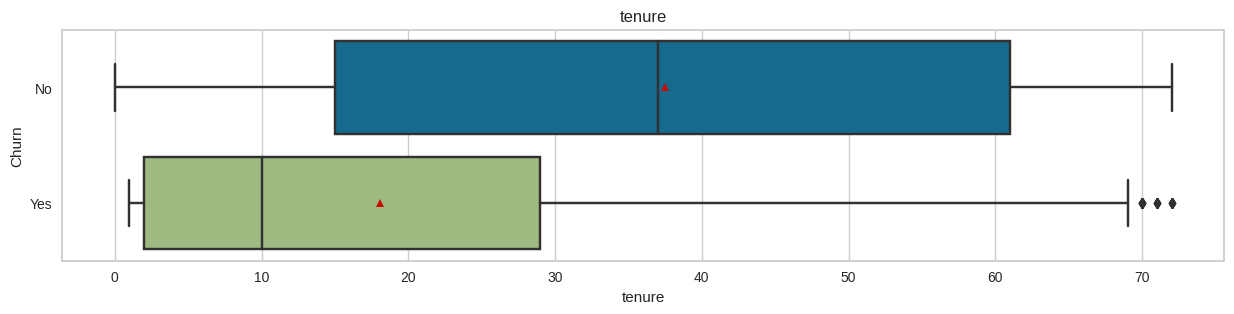

In [ ]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_hist_df, x="tenure", y="Churn", showmeans=True, orient="h")
plt.title("tenure")
plt.show()

Las variables PhoneService y MultipleLines no presentan una distribución significativamente diferente a Churn en niguno de los conjuntos poblacionales que representan. Por lo tanto, no se consideran relevantes.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["PhoneService"], normalize="columns")

MultipleLines      No  No phone service     Yes
Churn                                          
No            0.74679           0.75254 0.71666
Yes           0.25321           0.24746 0.28334

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["MultipleLines"], normalize="columns")

MultipleLines      No  No phone service     Yes
Churn                                          
No            0.74679           0.75254 0.71666
Yes           0.25321           0.24746 0.28334

Es claro que los usuarios que no cuentan con servicio de Internet son muy poco proclives a cancelar el servicio. Entre tanto, aquellos con fibra óptica tienen muchas más posibilidades que el promedio de cancelar. La conclusión es que la variable InternetService resultará ser uno de los predictores más significativos.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["InternetService"], normalize="columns")

InternetService     DSL  Fiber optic      No
Churn                                       
No              0.80883      0.58041 0.92624
Yes             0.19117      0.41959 0.07376

Dentro de los usuarios que sí tienen el servicio de Internet, tener seguridad online y/o backup online como servicios adicionales indica que la persona estará menos dispuesta a cancelar. Entonces OnlineSecurity y OnlineBackup son variables a tener en cuenta.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["OnlineSecurity"], normalize="columns")

OnlineSecurity      No  No internet service     Yes
Churn                                              
No             0.58111              0.92624 0.85291
Yes            0.41889              0.07376 0.14709

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["OnlineBackup"], normalize="columns")

OnlineBackup      No  No internet service     Yes
Churn                                            
No           0.59970              0.92624 0.78419
Yes          0.40030              0.07376 0.21581

Entre tanto, las personas que, teniendo el servicio de Internet, no usan protección de dispositivos o el soporte técnico son más propensas a cancelar que el promedio. Por lo que DeviceProtection y TechSupport serán consideradas variable relevantes.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["DeviceProtection"], normalize="columns")

DeviceProtection      No  No internet service     Yes
Churn                                                
No               0.60382              0.92624 0.77869
Yes              0.39618              0.07376 0.22131

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["TechSupport"], normalize="columns")

TechSupport      No  No internet service     Yes
Churn                                           
No          0.58475              0.92624 0.84438
Yes         0.41525              0.07376 0.15562

Por su parte, las personas que NO han contratado servicios de streaming (TV o películas) tienen una tendencia ligeramente mayor a cancelar que la población general. No es del todo clara su incidencia, pero StreamingTV y StreamingMovies se dejarán en la lista de predictores.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["StreamingTV"], normalize="columns")

StreamingTV      No  No internet service     Yes
Churn                                           
No          0.66134              0.92624 0.70108
Yes         0.33866              0.07376 0.29892

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["StreamingMovies"], normalize="columns")

StreamingMovies      No  No internet service     Yes
Churn                                               
No              0.65874              0.92624 0.70331
Yes             0.34126              0.07376 0.29669

Es evidente que las personas con contratos más largos son más propensas a permanecer más tiempo con su afiliación. No obstante, a priori esta observación podría esconder una trampa: ¿Podrían los usuarios de contratos largos no estar cancelando simmplemente porque su contrato no se lo permite?

Para responder a esto, se ha decidido revisar cómo ha sido la permanencia en la empresa de los clientes de contratos largos que llevan más de 2 años o 1 año, según sea el caso.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["Contract"], normalize="columns")

Contract  Month-to-month  One year  Two year
Churn                                       
No               0.57455   0.88141   0.97053
Yes              0.42545   0.11859   0.02947

Es muy claro que los clientes con contratos de 2 años tienden a permanecer mucho más con la empresa entre más tiempo hayan tenido el servicio.

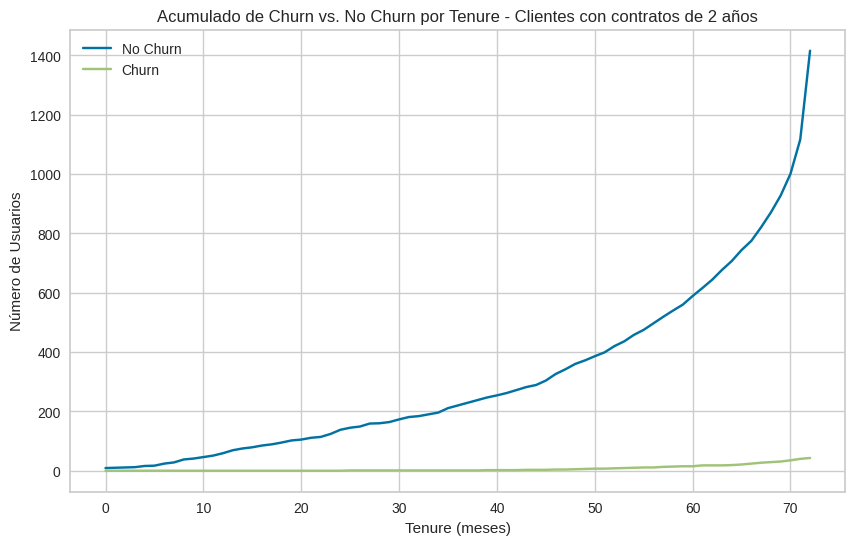

In [ ]:
df_2_years = churn_hist_df[churn_hist_df['Contract'] == 'Two year']
df_2_years['Churned'] = df_2_years['Churn'] == 'Yes'
df_2_years['Not_Churned'] = ~df_2_years['Churned']
cumulative_churned = df_2_years.groupby('tenure')['Churned'].sum().cumsum()
cumulative_not_churned = df_2_years.groupby('tenure')['Not_Churned'].sum().cumsum()

# Crear la gráfica XY
plt.figure(figsize=(10, 6))
plt.plot(cumulative_not_churned, label='No Churn')
plt.plot(cumulative_churned, label='Churn')
plt.title('Acumulado de Churn vs. No Churn por Tenure - Clientes con contratos de 2 años')
plt.xlabel('Tenure (meses)')
plt.ylabel('Número de Usuarios')
plt.legend()
plt.show()

Y lo mismo pasa con los clientes con contratos a 1 año, entre más tiempo hayan sido clientes, menos posibilidades de que cancelen. Por ende, la variable Contract será considerada un predictor de gran importancia.

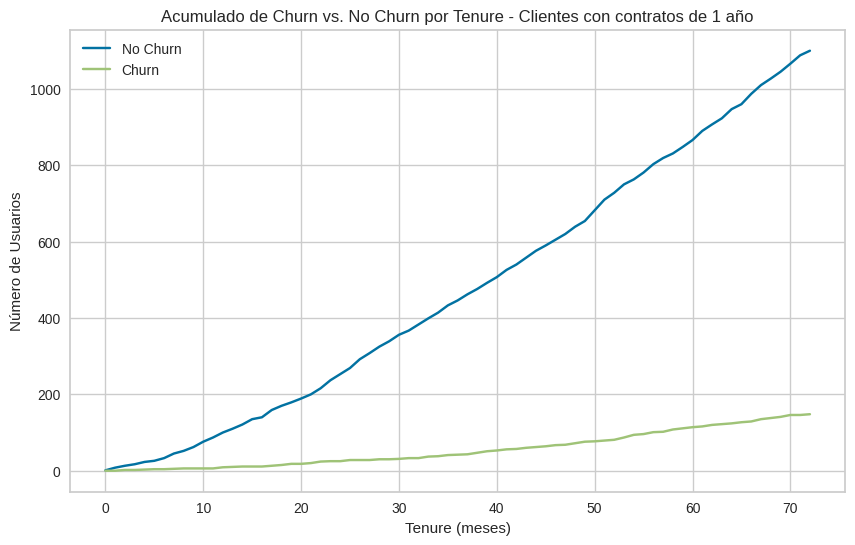

In [ ]:
df_1_years = churn_hist_df[churn_hist_df['Contract'] == 'One year']
df_1_years['Churned'] = df_1_years['Churn'] == 'Yes'
df_1_years['Not_Churned'] = ~df_1_years['Churned']
cumulative_churned = df_1_years.groupby('tenure')['Churned'].sum().cumsum()
cumulative_not_churned = df_1_years.groupby('tenure')['Not_Churned'].sum().cumsum()

# Crear la gráfica XY
plt.figure(figsize=(10, 6))
plt.plot(cumulative_not_churned, label='No Churn')
plt.plot(cumulative_churned, label='Churn')
plt.title('Acumulado de Churn vs. No Churn por Tenure - Clientes con contratos de 1 año')
plt.xlabel('Tenure (meses)')
plt.ylabel('Número de Usuarios')
plt.legend()
plt.show()

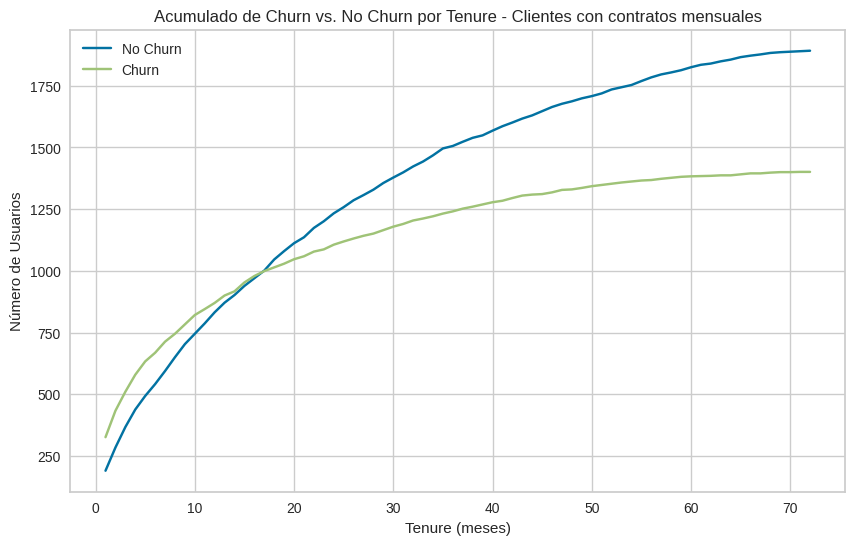

In [ ]:
df_month = churn_hist_df[churn_hist_df['Contract'] == 'Month-to-month']
df_month['Churned'] = df_month['Churn'] == 'Yes'
df_month['Not_Churned'] = ~df_month['Churned']
cumulative_churned = df_month.groupby('tenure')['Churned'].sum().cumsum()
cumulative_not_churned = df_month.groupby('tenure')['Not_Churned'].sum().cumsum()

# Crear la gráfica XY
plt.figure(figsize=(10, 6))
plt.plot(cumulative_not_churned, label='No Churn')
plt.plot(cumulative_churned, label='Churn')
plt.title('Acumulado de Churn vs. No Churn por Tenure - Clientes con contratos mensuales')
plt.xlabel('Tenure (meses)')
plt.ylabel('Número de Usuarios')
plt.legend()
plt.show()

Por su parte, los usuarios que reciben su facturación sin papel tienen más tendencia a cancelar que el promedio, y lo contrario pasa a los usuarios que sí gustan de las facturas impresas. Por lo que PaperlessBilling será una variable a considerar.



In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["PaperlessBilling"], normalize="columns")

PaperlessBilling      No     Yes
Churn                           
No               0.83655 0.66239
Yes              0.16345 0.33761

PaymentMethod será considerada como una variable relevante. Aquellos usuarios que pagan con transferencia bancaria, tarjeta de crédito o cheque por correo tienen una posibilidad menor que el promedio de cancelar. Pero, los usuarios que pagan con cheque electrónico tienen una probabilidad mucho más alta de irse.

In [ ]:
pd.crosstab(churn_hist_df["Churn"], churn_hist_df["PaymentMethod"], normalize="columns")

PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  \
Churn                                                               
No                               0.83566                  0.85219   
Yes                              0.16434                  0.14781   

PaymentMethod  Electronic check  Mailed check  
Churn                                          
No                      0.54581       0.80739  
Yes                     0.45419       0.19261

Entrando al tema de los pagos, es notorio que aquellos que deciden cancelar pagan en promedio una cantidad más alta cada mes. Esto puede deberse a que tienen más servicios contratados (como el servicio de Internet) o a que tienen tarifas más altas que no han sido actualizadas a la baja para generarles una oferta más competitiva.

MonthlyCharges efectivamente será usada en el clasificador.

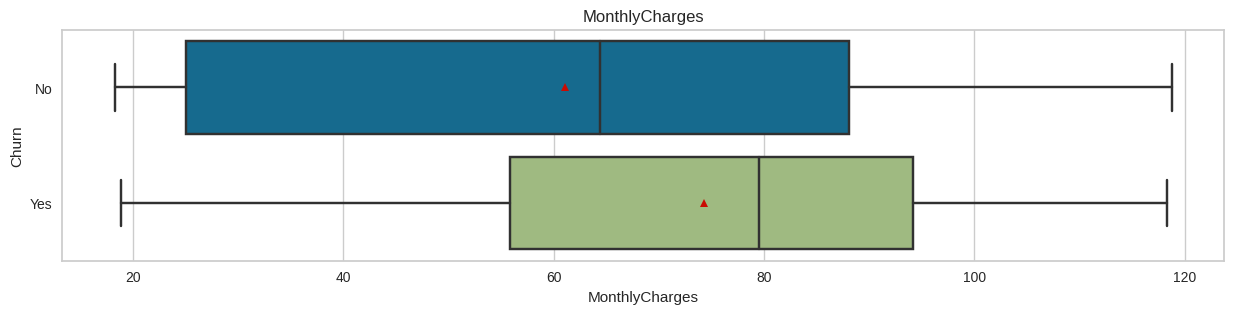

In [ ]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_hist_df, x="MonthlyCharges", y="Churn", showmeans=True, orient="h")
plt.title("MonthlyCharges")
plt.show()

Y por último, se observa que el total acumulado de los cobros históricos es más bajo para quienes deciden cancelar (contrario a lo que pasa con los cobros mensuales). Sin embargo, esto tiene una razón, y es que quienes deciden cancelar suelen llevar menos tiempo en promedio como clientes de la empresa, por lo que sus cobros acumulados han de ser menores.

Se considera entonces que la variable TotalCharges será tenida en cuenta para el modelo principal.

In [ ]:
churn_parcial_df = churn_hist_df[churn_hist_df['TotalCharges'] != '']
churn_parcial_df.shape

(5990, 21)

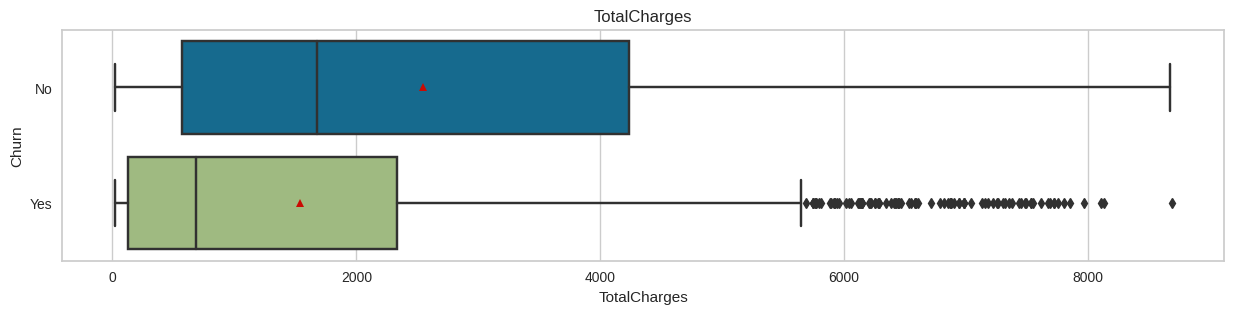

In [ ]:
plt.figure(figsize=(15, 3))
sns.boxplot(data=churn_parcial_df, x="TotalCharges", y="Churn", showmeans=True, orient="h")
plt.title("TotalCharges")
plt.show()

### **1.4 Análisis bivariado - Cuantificación**


In [ ]:
churn_parcial_df['Churn'] = churn_parcial_df['Churn'].replace({'Yes': 1, 'No': 0})

Los valores de KS Stat y p-value obtenido para las 3 variables numéricas confirman que estas pueden ser buenos clasificadores.

In [ ]:
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

ks_results = []
for f in numerical_features:
    ks_stat, p_value = ks_2samp(churn_parcial_df.loc[churn_parcial_df["Churn"] == 1, f], churn_parcial_df.loc[churn_parcial_df["Churn"] == 0, f])
    ks_results.append({
        "Feature": f,
        "KS stat": ks_stat,
        "p-value": p_value
    })
pd.DataFrame(ks_results)

Feature  KS stat  p-value
0          tenure  0.35396  0.00000
1  MonthlyCharges  0.24785  0.00000
2    TotalCharges  0.22249  0.00000

Entre tanto, el análisis cuantitativo para las variables catégoricas confirma lo que ya se había propuesto en la sección anterior para cada una de  las variables. En resumen, las columnas que no serán usadas como clasificadores por su poca relevancia son:



*   gender
*   PhoneService
*   MultipleLines

Sin embargo, para la selección de hiperparámetros se formarán dos conjuntos de variables de entrada. Uno que no incluya estas variables sin relevancia, y otro que sí las incluya. Esto para dar dos alternativas al buscador de hiperparámetros en este aspecto.


In [ ]:
categorical_features = ["gender", "SeniorCitizen", "Partner", "Dependents",
            "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
            "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]

chi2_results = []
for f in categorical_features:
    onehot = OneHotEncoder(sparse=False)
    t = onehot.fit_transform(churn_parcial_df[[f]])
    values = onehot.categories_[0]
    chi2_stats, p_values = chi2(t, churn_parcial_df["Churn"])

    for value, chi_stat, p_value in zip(values, chi2_stats, p_values):
        chi2_results.append({
            "Feature": f,
            "Value": value,
            "Chi2 stat": chi_stat,
            "p-value": p_value
        })
pd.DataFrame(chi2_results)


Feature                      Value  Chi2 stat  p-value
0             gender                     Female    0.29502  0.58702
1             gender                       Male    0.28552  0.59311
2      SeniorCitizen                          0   21.89658  0.00000
3      SeniorCitizen                          1  114.58681  0.00000
4            Partner                         No   70.55182  0.00000
5            Partner                        Yes   75.42587  0.00000
6         Dependents                         No   52.75501  0.00000
7         Dependents                        Yes  122.70446  0.00000
8       PhoneService                         No    0.92038  0.33738
9       PhoneService                        Yes    0.10018  0.75161
10     MultipleLines                         No    2.16930  0.14079
11     MultipleLines           No phone service    0.92038  0.33738
12     MultipleLines                        Yes    4.14449  0.04177
13   InternetService                        DSL   57.91722  0.00000
14   InternetService                Fiber optic  318.12684  0.00000
15   InternetService                         No  246.77947  0.00000
16    OnlineSecurity                         No  356.73533  0.00000
17    OnlineSecurity        No internet service  246.77947  0.00000
18    OnlineSecurity                        Yes  123.15121  0.00000
19      OnlineBackup                         No  243.72670  0.00000
20      OnlineBackup        No internet service  246.77947  0.00000
21      OnlineBackup                        Yes   25.89015  0.00000
22  DeviceProtection                         No  228.76999  0.00000
23  DeviceProtection        No internet service  246.77947  0.00000
24  DeviceProtection                        Yes   20.48395  0.00001
25       TechSupport                         No  338.30016  0.00000
26       TechSupport        No internet service  246.77947  0.00000
27       TechSupport                        Yes  106.93850  0.00000
28       StreamingTV                         No   65.00572  0.00000
29       StreamingTV        No internet service  246.77947  0.00000
30       StreamingTV                        Yes   13.35880  0.00026
31   StreamingMovies                         No   69.72850  0.00000
32   StreamingMovies        No internet service  246.77947  0.00000
33   StreamingMovies                        Yes   11.49799  0.00070
34          Contract             Month-to-month  430.23187  0.00000
35          Contract                   One year  138.26004  0.00000
36          Contract                   Two year  414.27911  0.00000
37  PaperlessBilling                         No  132.02425  0.00000
38  PaperlessBilling                        Yes   93.47482  0.00000
39     PaymentMethod  Bank transfer (automatic)   67.57106  0.00000
40     PaymentMethod    Credit card (automatic)   92.39246  0.00000
41     PaymentMethod           Electronic check  369.28650  0.00000
42     PaymentMethod               Mailed check   36.68490  0.00000

### **1.5 Análisis gráfico - XY**

Por último, y a modo ilustrativo, se usa un PCA para graficar los datos en un plano XY y conocer cómo se vería su distribución en dos dimensiones. Esto posiblemente contribuya a elegir los modelos de clasificación que mejor se adapten a la distribución de estos datos.

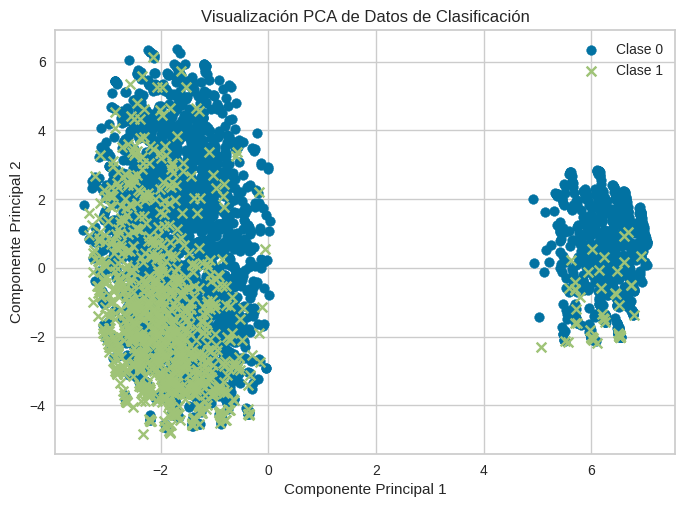

In [109]:
features_cat = ["gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService", "MultipleLines",
                "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport",
                "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]

features_num = ["tenure", "MonthlyCharges", "TotalCharges"]

df_filtered = churn_df[churn_df['TotalCharges'] != '']

encoder = OneHotEncoder()
X_categorical_encoded = encoder.fit_transform(df_filtered[features_cat]).toarray()
X_combined = np.concatenate((df_filtered[features_num], X_categorical_encoded), axis=1)

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_combined)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

X_train, X_test, y_train, y_test = train_test_split(X_pca, df_filtered["Churn"], test_size=0.2, random_state=42)

fig, ax = plt.subplots()
scatter_0 = ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='Clase 0', marker='o')
scatter_1 = ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Clase 1', marker='x')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_title('Visualización PCA de Datos de Clasificación')
ax.legend()

plt.show()

# **2. Encapsulamiento de la transformación de los datos, entrenamiento y predicción**

### **2.1 Modelo base**

In [4]:
features = ["gender", "SeniorCitizen", "Partner", "Dependents", "tenure",
            "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
            "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod",
            "MonthlyCharges", "TotalCharges"]

In [5]:
churn_hist_df['Churn'] = churn_hist_df['Churn'].replace({'Yes': 1, 'No': 0})
churn_fut_df['Churn'] = churn_fut_df['Churn'].replace({'Yes': 1, 'No': 0})

In [6]:
churn_df, test_df = train_test_split(churn_hist_df, test_size=0.2, random_state=42)

In [10]:
replace_empty_string_transformer = FunctionTransformer(func=transformersMethods.replace_empty_with_zero,feature_names_out=transformersMethods.feature_names)

categorical_transformer = OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                                               'gender', 'SeniorCitizen', 'MultipleLines', 'InternetService',
                                               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                               'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']),
        ('tenure', replace_empty_string_transformer, ['tenure']),
        ('MonthlyCharges', replace_empty_string_transformer, ['MonthlyCharges']),
        ('TotalCharges', replace_empty_string_transformer, ['TotalCharges']),
    ],
    remainder='drop'
)


In [9]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    #('scaler', StandardScaler()),
    ("classifier",  RandomForestClassifier(random_state=10))
])

In [10]:
param_grid = {
    "classifier__n_estimators": [5],
    "classifier__max_depth" : [3],
    #"classifier__class_weight": ["balanced", None]
}

In [11]:
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=["precision", "recall", "f1", "roc_auc"],
                    refit="f1", cv=5, return_train_score=True)

In [12]:
grid.fit(churn_df[features], churn_df["Churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          '...
                                                                         FunctionTransformer(feature_names_out=<function feature_names at 0x7f9e4bff6e60>,
                                                                                             func=<function replace_empty_with_zero at 0x7f9e4d1612d0>),
                                                                         ['TotalCharges'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=10))]),
             param_grid={'classifier__max_depth': [3],
                         'classifier__n_estimators': [5]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1', 'roc_auc'])

In [13]:
grid.best_params_

{'classifier__max_depth': 3, 'classifier__n_estimators': 5}

In [14]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

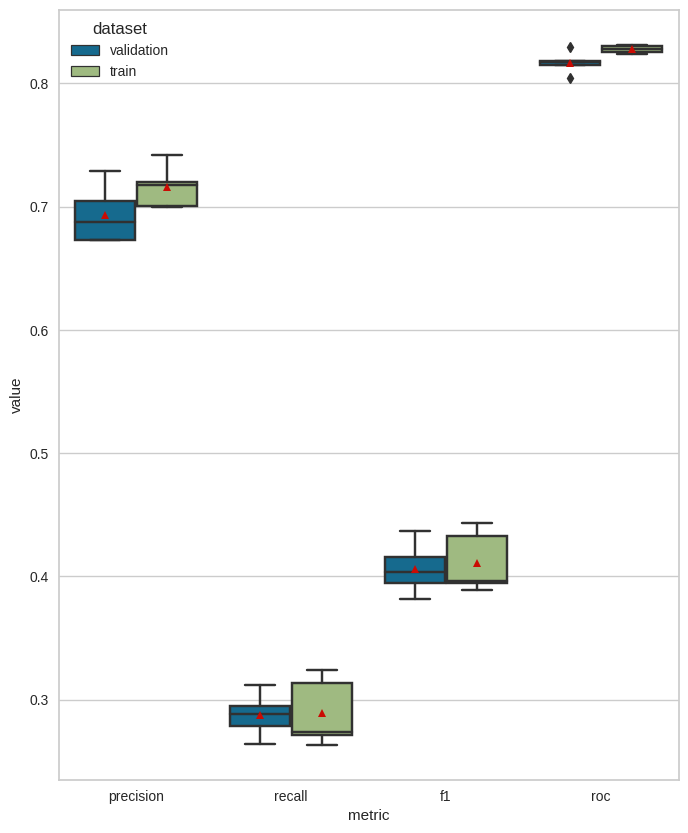

In [15]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [16]:
train_val_preds = grid.best_estimator_.predict(churn_df[features])
test_preds = grid.best_estimator_.predict(test_df[features])

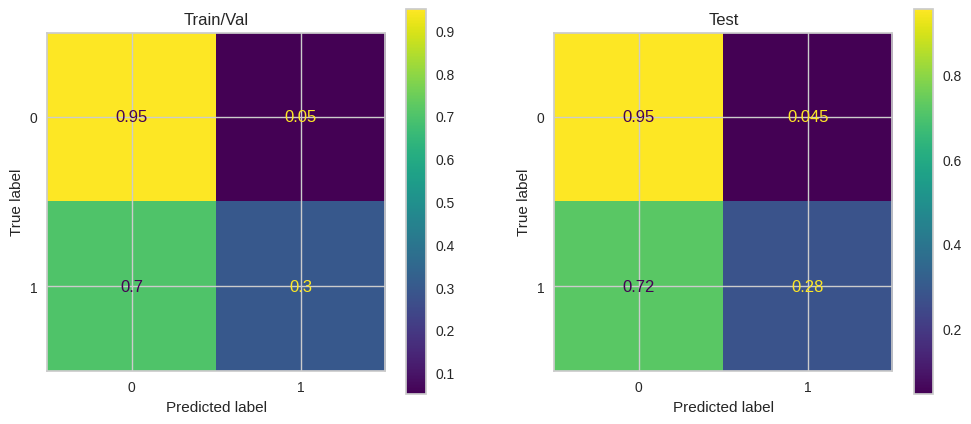

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

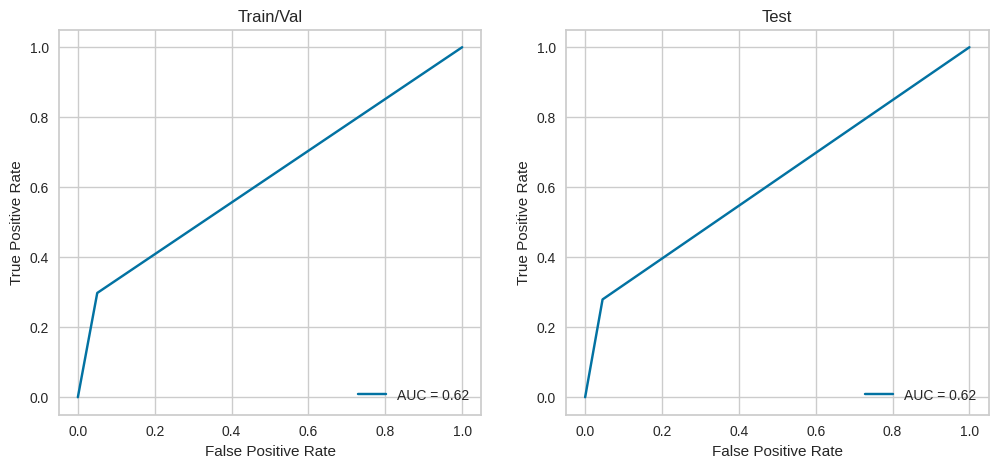

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(churn_df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [19]:
print("Precision:")
print("- Train/Val:", precision_score(churn_df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.6757246376811594
- Test: 0.7089552238805971

Recall:
- Train/Val: 0.2979233226837061
- Test: 0.27941176470588236

F1:
- Train/Val: 0.41352549889135254
- Test: 0.40084388185654013

ROC AUC:
- Train/Val: 0.6237361821986738
- Test: 0.6170314637482901


In [1]:
test_probs = grid.best_estimator_.predict_proba(test_df[features])[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

NameError: ignored

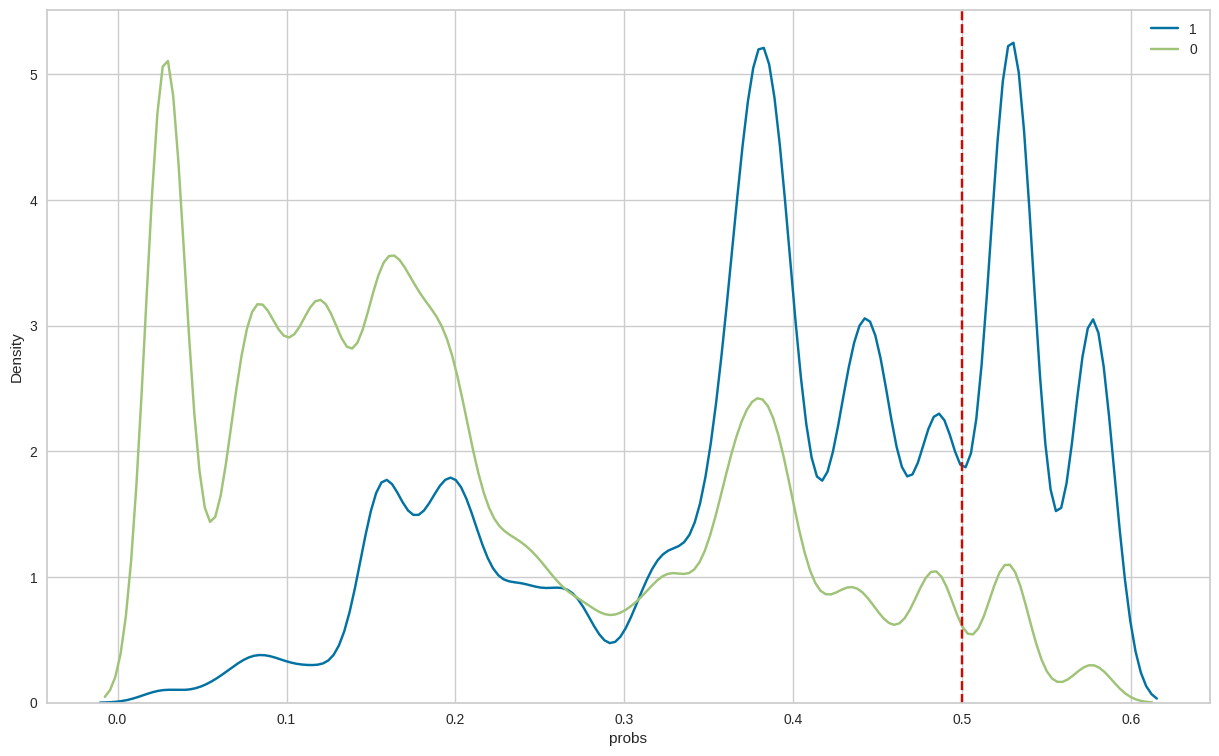

In [21]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

In [22]:
dump(grid.best_estimator_, "./churn-v1.joblib")

['./churn-v1.joblib']

### **2.2 Mejor modelo - Selección automática**



Se procederá ahora a realizar una búsqueda más exhaustiva de hiperparámetros para tres modelos diferentes: Random Forest, Regresión logística y XXX. El mejor modelo será escogido principalmente a través de la métrica F1-Score.

In [24]:
replace_empty_string_transformer = FunctionTransformer(func=transformersMethods.replace_empty_with_zero,feature_names_out=transformersMethods.feature_names)

categorical_transformer = OneHotEncoder(sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
                                               'gender', 'SeniorCitizen', 'MultipleLines', 'InternetService',
                                               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                               'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']),
        ('tenure', replace_empty_string_transformer, ['tenure']),
        ('MonthlyCharges', replace_empty_string_transformer, ['MonthlyCharges']),
        ('TotalCharges', replace_empty_string_transformer, ['TotalCharges']),
    ],
    remainder='drop'
)


### **2.2.1 Random Forest**

Partiendo de los 3 preprocesadores, se crea ahora el pipeline y la grilla de búsqueda **(GridSearch Cross Validation)** para un modelo Random Forest. No se prueban aquí estrategías de estandarización de datos porque no son necesarias para Random Forest. Lo que sí se hace es dejar como hiperparámetro el balancear o no la clase minoritaria (en este caso aquellos clientes que cancelan):

In [188]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),  # Selector de características
    ('classifier', RandomForestClassifier())
])

In [189]:
param_grid = {
    'feature_selection__k': [8, 15, 20],  # Número de características a seleccionar
    "classifier__n_estimators": [10, 25, 50, 100, 200],
    "classifier__max_depth" : [3, 5, 7, 10, 20],
    "classifier__class_weight": ["balanced", None]
}

In [190]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    scoring='f1',
                    refit="f1", cv=5, return_train_score=True)

In [191]:
grid.fit(churn_df[features], churn_df["Churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          '...
                                                                                             func=<function replace_empty_with_zero at 0x7f9e4d1612d0>),
                                                                         ['TotalCharges'])])),
                                       ('feature_selection', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [3, 5, 7, 10, 20],
                         'classifier__n_estimators': [10, 25, 50, 100, 200],
                         'feature_selection__k': [8, 15, 20]},
             refit='f1', return_train_score=True, scoring='f1')

In [192]:
grid.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 7,
 'classifier__n_estimators': 10,
 'feature_selection__k': 8}

In [193]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

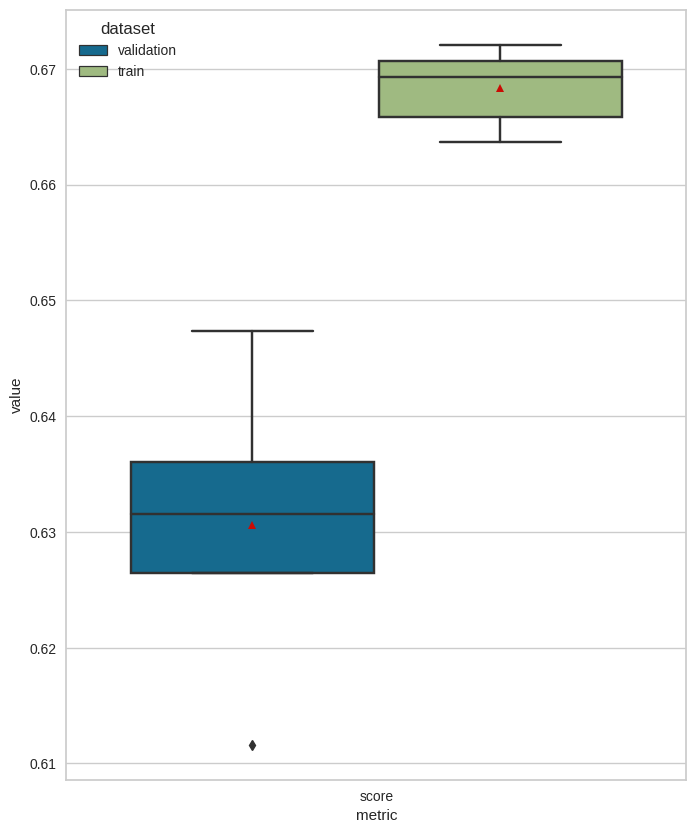

In [194]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [195]:
train_val_preds = grid.best_estimator_.predict(churn_df[features])
test_preds = grid.best_estimator_.predict(test_df[features])

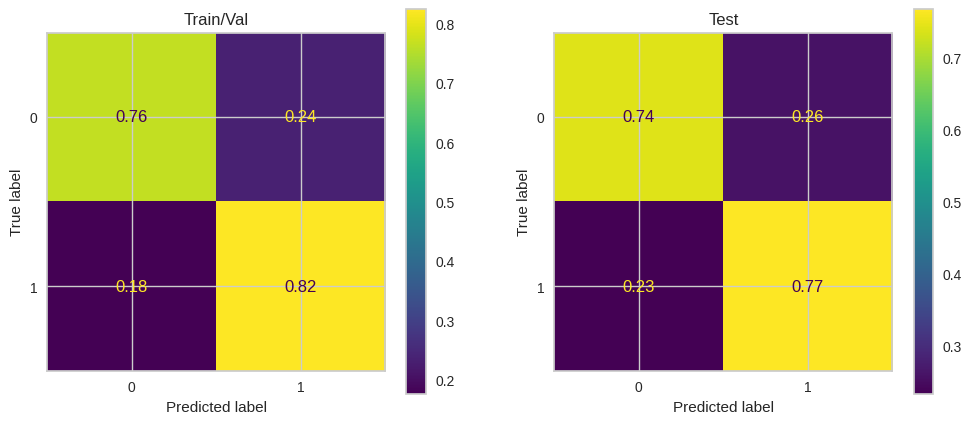

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

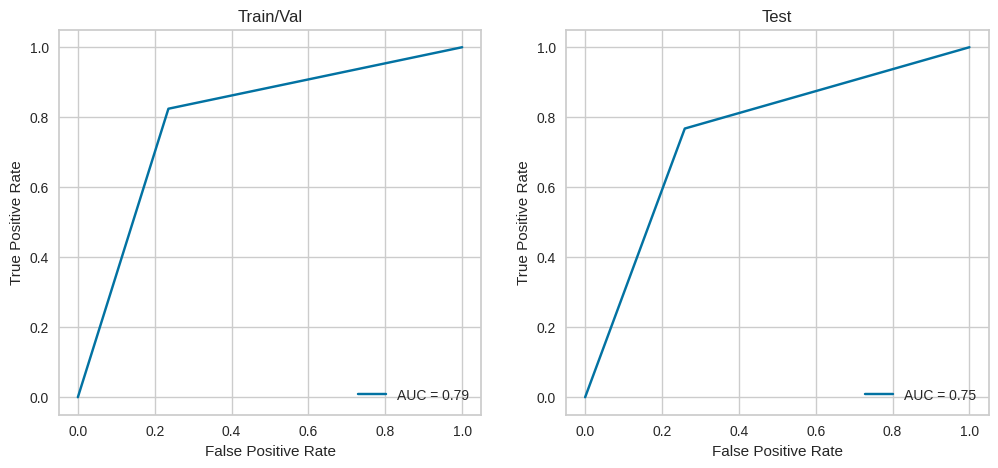

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(churn_df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [198]:
print("Precision:")
print("- Train/Val:", precision_score(churn_df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.5524625267665952
- Test: 0.5392561983471075

Recall:
- Train/Val: 0.8242811501597445
- Test: 0.7676470588235295

F1:
- Train/Val: 0.6615384615384615
- Test: 0.633495145631068

ROC AUC:
- Train/Val: 0.7943277227687109
- Test: 0.7541723666210671


In [199]:
test_probs = grid.best_estimator_.predict_proba(test_df[features])[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

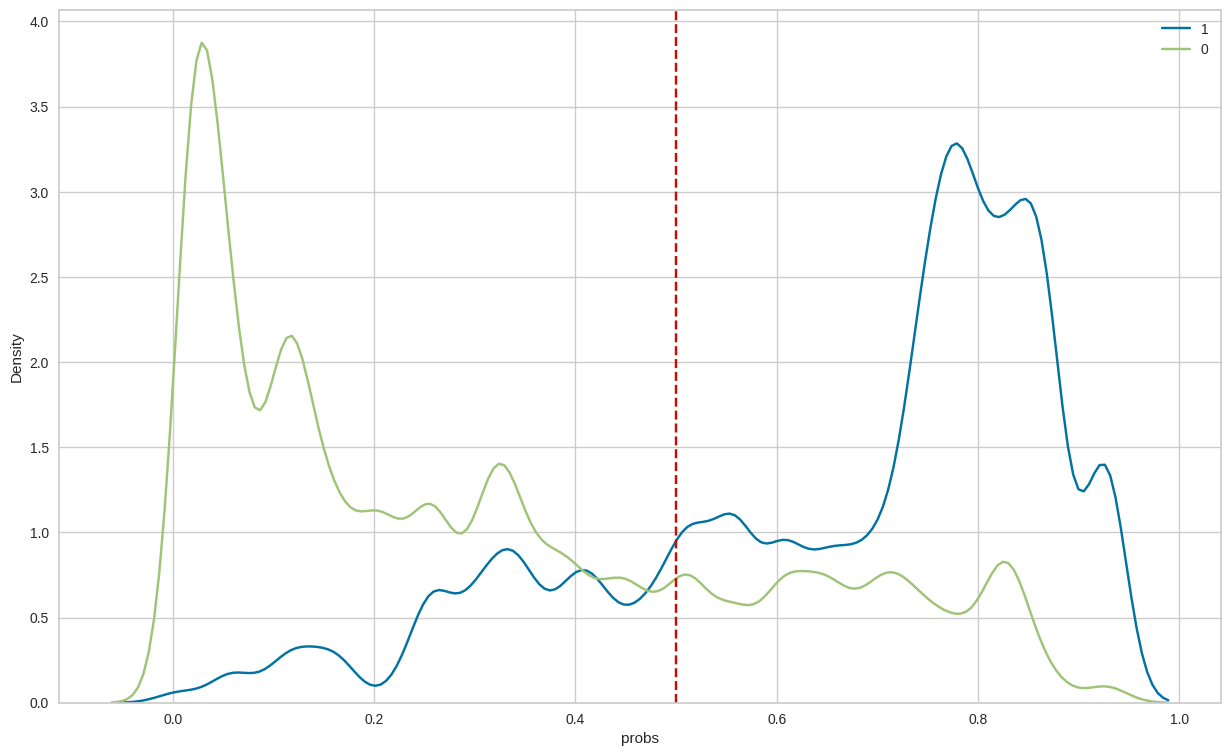

In [200]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

In [202]:
dump(grid.best_estimator_, "./churn-v2_RF.joblib")

['./churn-v2_RF.joblib']

### **2.2.2 Regresión logística**

Se probará ahora el clásico modelo de regresión logística, nuevamente utilizando  **(GridSearch Cross Validation)**. Esta vez sí se incluirán diferentes alternativas de estandarización en la búsqueda de hiperparámetros. Además, se buscarán los hiperparámetros típicos de un modelo de regresión logística. También se deja abierta la opción de balancear o no la clase minoritaria:

In [203]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', LogisticRegression())
])


In [204]:
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'feature_selection__k': [8, 15, 20],  # Número de características a seleccionar
    'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "classifier__class_weight": ["balanced", None]
}

In [205]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    scoring='f1',
                    refit="f1", cv=5, return_train_score=True)

In [206]:
grid.fit(churn_df[features], churn_df["Churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          '...
             param_grid={'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10,
                                           100],
                         'classifier__class_weight': ['balanced', None],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet',
                                                 'none'],
                         'classifier__solver': ['newton-cg', 'lbfgs',
                                                'liblinear', 'sag', 'saga'],
                         'feature_selection__k': [8, 15, 20],
                         'scaler': [StandardScaler(), MinMaxScaler()]},
             refit='f1', return_train_score=True, scoring='f1')

In [207]:
grid.best_params_

{'classifier__C': 0.001,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'classifier__solver': 'liblinear',
 'feature_selection__k': 20,
 'scaler': StandardScaler()}

In [208]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

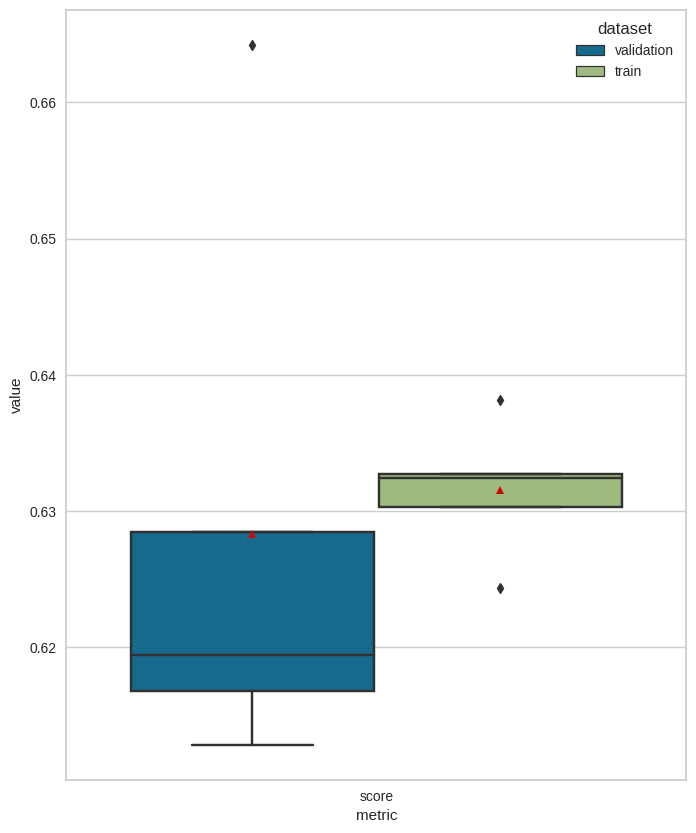

In [209]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [210]:
train_val_preds = grid.best_estimator_.predict(churn_df[features])
test_preds = grid.best_estimator_.predict(test_df[features])

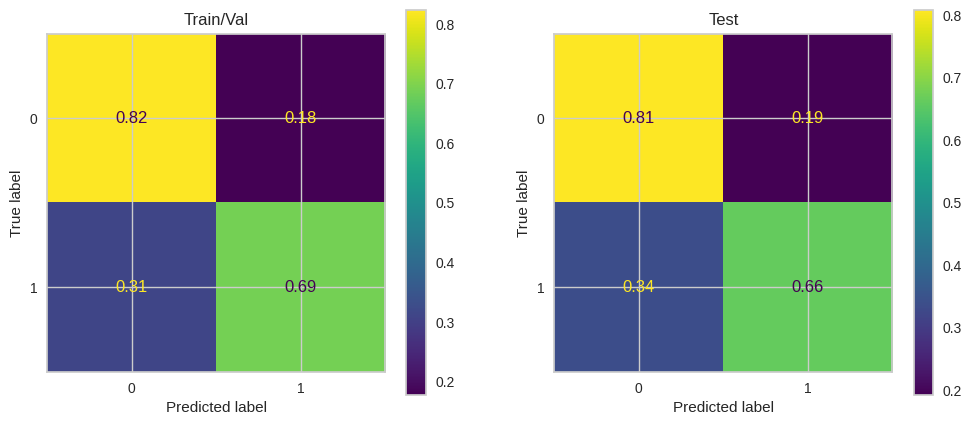

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

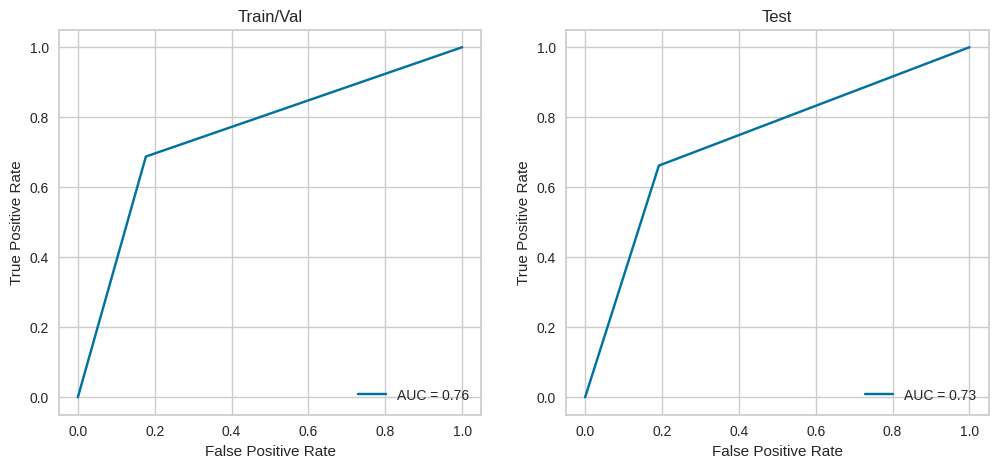

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(churn_df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [213]:
print("Precision:")
print("- Train/Val:", precision_score(churn_df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.5782404298186703
- Test: 0.5769230769230769

Recall:
- Train/Val: 0.6876996805111821
- Test: 0.6617647058823529

F1:
- Train/Val: 0.6282378693907333
- Test: 0.6164383561643835

ROC AUC:
- Train/Val: 0.7553492765577331
- Test: 0.7349521203830369


In [214]:
test_probs = grid.best_estimator_.predict_proba(test_df[features])[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

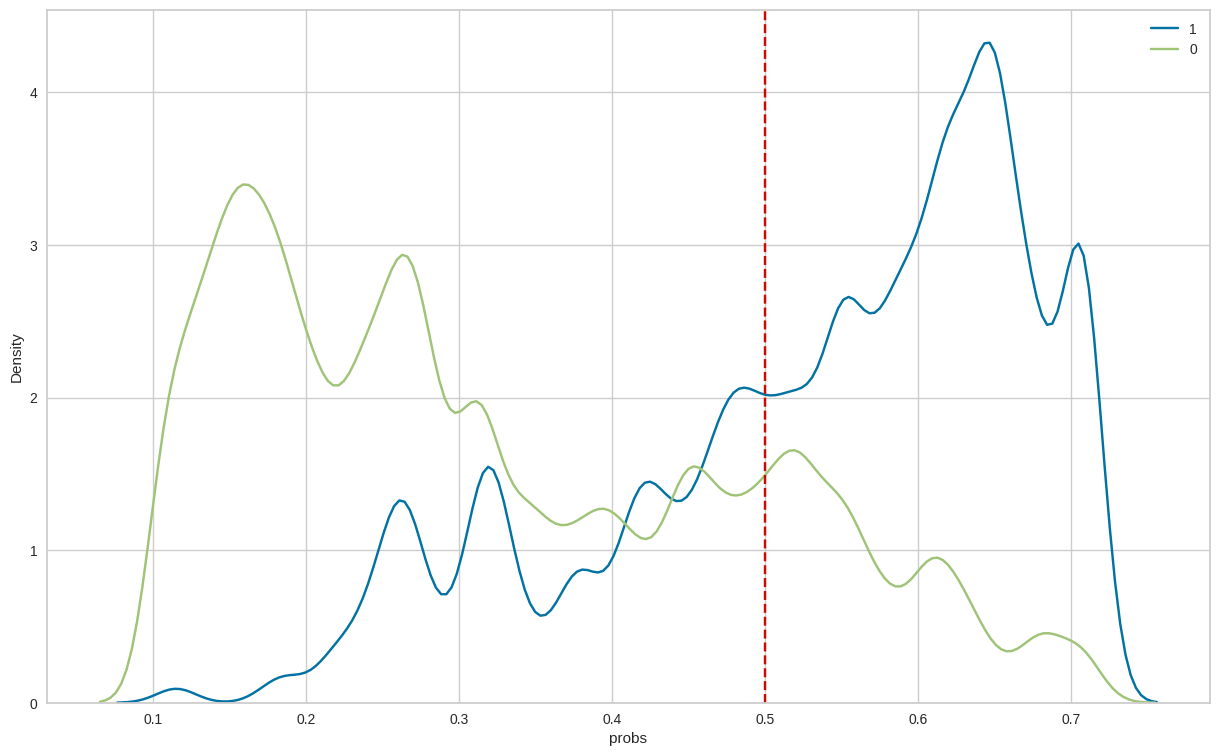

In [215]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

In [216]:
dump(grid.best_estimator_, "./churn-v2_LR.joblib")

['./churn-v2_LR.joblib']

### **2.2.3 XGBoost**

Teniendo en cuenta la distribución de los datos observada al graficar los componentes principales derivados de un PC, se prueba ahora un XGBoost. Este podría ser un buen método, teniendo en cuenta que es un buen clasificador binario y se adapta bien a datos no lineales. Se crea ahora entonces el pipeline y la grilla de búsqueda **(GridSearch Cross Validation)**:

In [11]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif)),
    ('classifier', XGBClassifier(n_jobs=-1))
])

In [12]:
param_grid = {
    'feature_selection__k': [8, 15, 20],  # Número de características a seleccionar
    "classifier__class_weight": ["balanced", None],
    'classifier__n_estimators': [5, 10, 25, 50],
    'classifier__scale_pos_weight': [1, 2, 4, 8],
    'classifier__tree_method': ['hist', 'approx'],
}

In [13]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    scoring='f1',
                    refit="f1", cv=5, return_train_score=True)

In [14]:
grid.fit(churn_df[features], churn_df["Churn"])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['Partner',
                                                                          'Dependents',
                                                                          'PhoneService',
                                                                          'PaperlessBilling',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          '...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__n_estimators': [5, 10, 25, 50],
                         'classifier__scale_pos_weight': [1, 2, 4, 8],
                         'classifier__tree_method': ['hist', 'approx'],
                         'feature_selection__k': [8, 15, 20]},
             refit='f1', return_train_score=True, scoring='f1')

In [15]:
grid.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__n_estimators': 10,
 'classifier__scale_pos_weight': 2,
 'classifier__tree_method': 'hist',
 'feature_selection__k': 15}

In [17]:
best_results_df = pd.DataFrame(grid.cv_results_).iloc[grid.best_index_].reset_index().rename(columns={"index": "result", grid.best_index_: "value"})
best_results_df = best_results_df.loc[best_results_df["result"].str.contains("split")]
[best_results_df["split"], best_results_df["dataset"], best_results_df["metric"]] = zip(*best_results_df["result"].str.split("_"))
best_results_df["dataset"].replace({"test": "validation"}, inplace=True)
del best_results_df["result"]

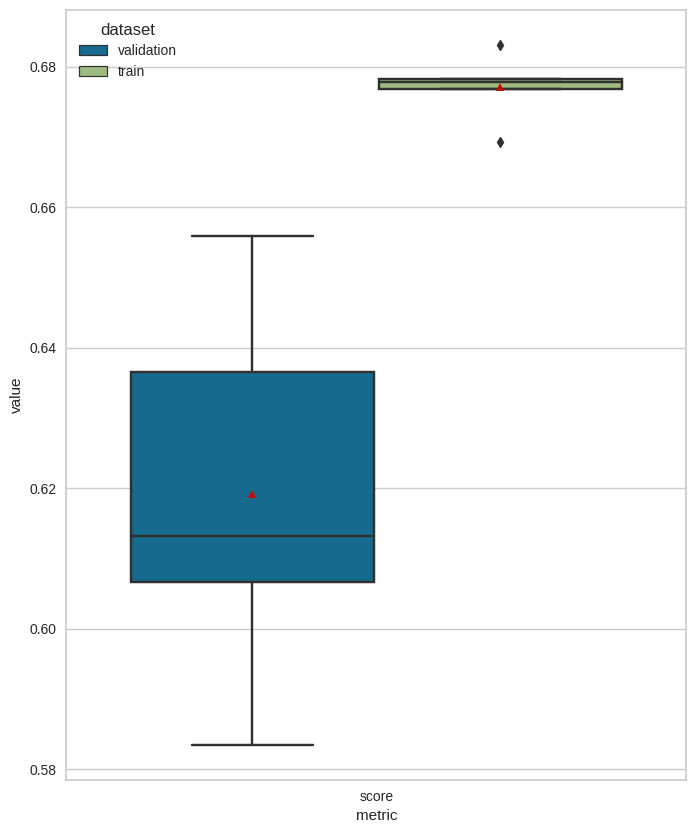

In [18]:
plt.figure(figsize=(8, 10))
sns.boxplot(data=best_results_df, y="value", x="metric", hue="dataset", showmeans=True)
plt.show()

In [19]:
train_val_preds = grid.best_estimator_.predict(churn_df[features])
test_preds = grid.best_estimator_.predict(test_df[features])

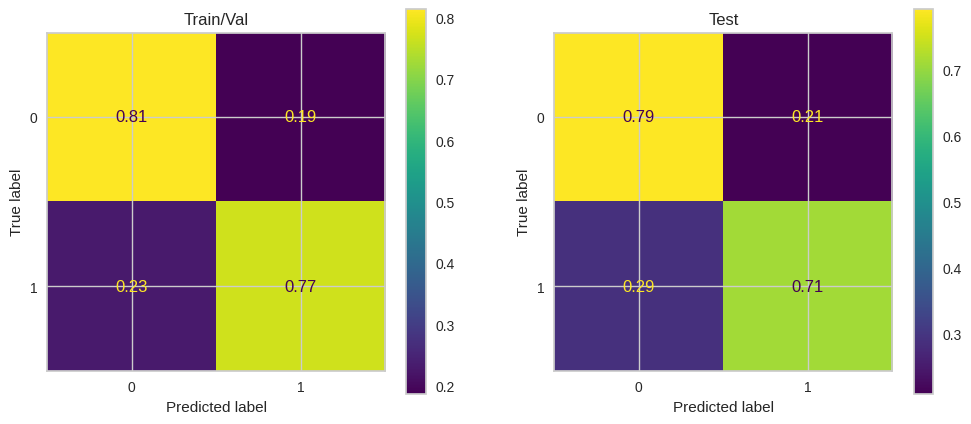

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_val_cm = confusion_matrix(churn_df["Churn"], train_val_preds, labels=grid.best_estimator_.classes_, normalize="true")
train_val_disp = ConfusionMatrixDisplay(confusion_matrix=train_val_cm, display_labels=grid.best_estimator_.classes_)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

test_cm = confusion_matrix(test_df["Churn"], test_preds, labels=grid.best_estimator_.classes_, normalize="true")
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=grid.best_estimator_.classes_)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

plt.show()

Text(0.5, 1.0, 'Test')

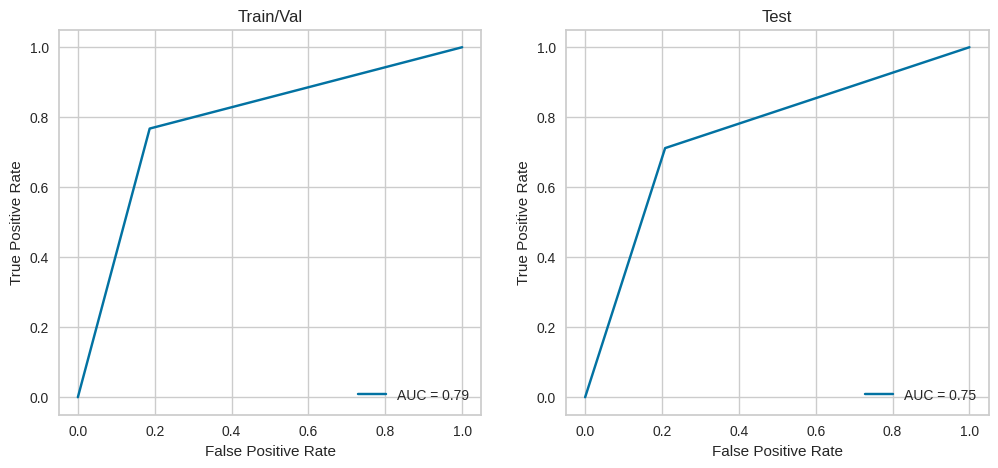

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

fpr, tpr, thresholds = roc_curve(churn_df["Churn"], train_val_preds)
area = auc(fpr, tpr)
train_val_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
train_val_disp.plot(ax=axes[0])
axes[0].set_title("Train/Val")

fpr, tpr, thresholds = roc_curve(test_df["Churn"], test_preds)
area = auc(fpr, tpr)
test_disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=area)
test_disp.plot(ax=axes[1])
axes[1].set_title("Test")

In [22]:
print("Precision:")
print("- Train/Val:", precision_score(churn_df["Churn"], train_val_preds))
print("- Test:", precision_score(test_df["Churn"], test_preds))
print("\nRecall:")
print("- Train/Val:", recall_score(churn_df["Churn"], train_val_preds))
print("- Test:", recall_score(test_df["Churn"], test_preds))
print("\nF1:")
print("- Train/Val:", f1_score(churn_df["Churn"], train_val_preds))
print("- Test:", f1_score(test_df["Churn"], test_preds))
print("\nROC AUC:")
print("- Train/Val:", roc_auc_score(churn_df["Churn"], train_val_preds))
print("- Test:", roc_auc_score(test_df["Churn"], test_preds))

Precision:
- Train/Val: 0.5917487684729064
- Test: 0.5748218527315915

Recall:
- Train/Val: 0.7675718849840255
- Test: 0.711764705882353

F1:
- Train/Val: 0.668289290681502
- Test: 0.6360052562417872

ROC AUC:
- Train/Val: 0.7903530225371086
- Test: 0.751812585499316


In [23]:
test_probs = grid.best_estimator_.predict_proba(test_df[features])[:,1]
probs_true_df = pd.DataFrame(np.append(test_probs.reshape(-1, 1), test_df["Churn"].values.reshape(-1, 1), axis=1), columns=["probs", "true"])

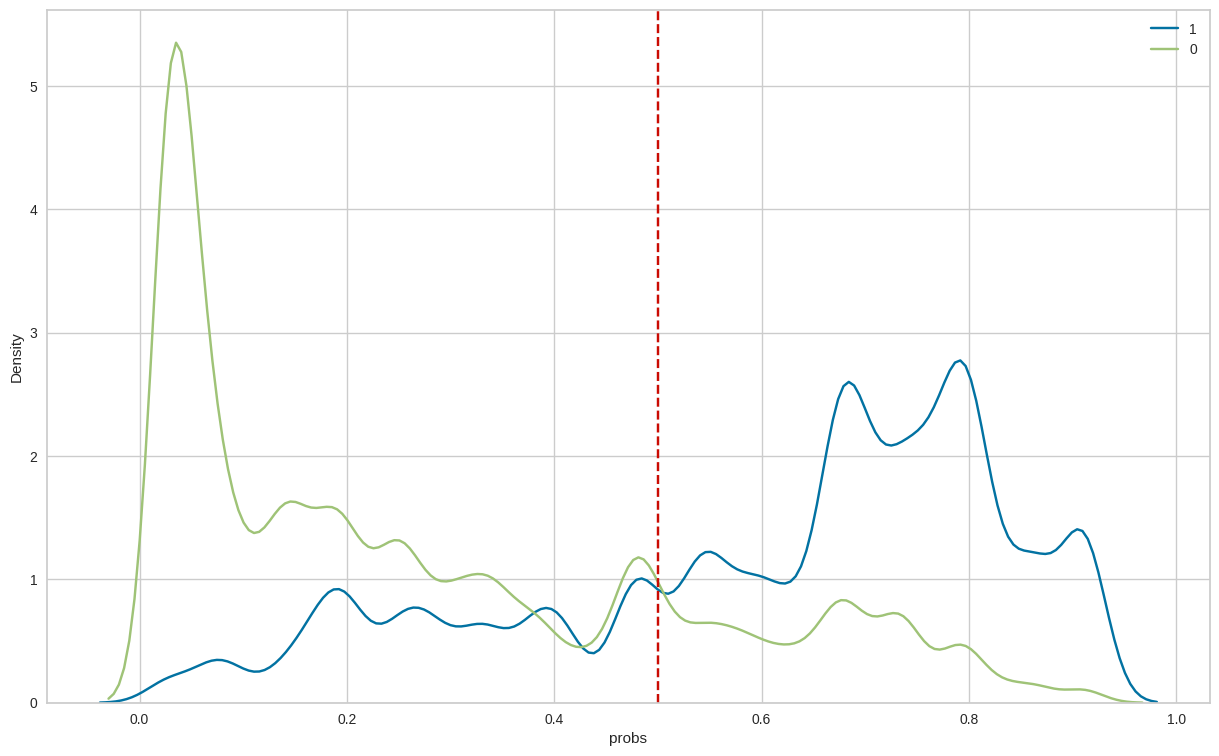

In [24]:
plt.figure(figsize=(15, 9))
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 1], x="probs", bw_adjust=.3, label="1")
sns.kdeplot(data=probs_true_df.loc[probs_true_df["true"] == 0], x="probs", bw_adjust=.3, label="0")
plt.axvline(x=.5, color="r", linestyle="--")
plt.legend()
plt.show()

In [263]:
dump(grid.best_estimator_, "./churn-v2_XGB.joblib")

['./churn-v2_XGB.joblib']

### **2.3 Explicación de las predicciones del mejor modelo**

A continuación se procede a explicar las predicciones obtenidas con el modelo XGBoost, incluyendo la influencia de las variables de entrada en la decisión.

In [25]:
test_df["prob"] = test_probs

In [26]:
test_df.sort_values(by="prob").head()

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
408   8207-DMRVL    Male              0     Yes        Yes      72   
4708  7173-TETGO  Female              1     Yes         No      72   
3618  5451-YHYPW  Female              1     Yes         No      72   
4317  0254-FNMCI  Female              0      No         No      72   
1777  2878-RMWXY    Male              1     Yes         No      72   

     PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
408           Yes           Yes     Fiber optic            Yes          Yes   
4708          Yes           Yes     Fiber optic            Yes           No   
3618          Yes           Yes     Fiber optic            Yes          Yes   
4317          Yes            No     Fiber optic            Yes          Yes   
1777          Yes           Yes     Fiber optic            Yes          Yes   

     DeviceProtection TechSupport StreamingTV StreamingMovies  Contract  \
408               Yes         Yes         Yes             Yes  Two year   
4708               No          No          No              No  Two year   
3618              Yes         Yes         Yes             Yes  Two year   
4317              Yes         Yes         Yes             Yes  Two year   
1777              Yes          No          No             Yes  Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
408                No  Bank transfer (automatic)       114.55000   8306.05000   
4708               No  Bank transfer (automatic)        78.50000   5602.25000   
3618              Yes    Credit card (automatic)       115.75000   8443.70000   
4317              Yes           Electronic check       109.90000   7624.20000   
1777              Yes    Credit card (automatic)       102.65000   7550.30000   

      Churn    prob  
408       0 0.02681  
4708      0 0.02681  
3618      0 0.02681  
4317      0 0.02681  
1777      0 0.02681

In [27]:
test_df.sort_values(by="prob", ascending=False).head()

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
5937  6230-BSUXY  Female              1      No         No       1   
1407  6910-HADCM  Female              0      No         No       1   
4454  8062-YBDOE    Male              1      No         No       1   
776   5875-YPQFJ    Male              0      No         No       1   
1383  8380-PEFPE    Male              0      No        Yes       1   

     PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
5937          Yes            No     Fiber optic             No           No   
1407          Yes            No     Fiber optic             No           No   
4454          Yes            No     Fiber optic             No           No   
776           Yes            No     Fiber optic             No           No   
1383          Yes            No     Fiber optic             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
5937              Yes          No          No             Yes  Month-to-month   
1407              Yes          No          No              No  Month-to-month   
4454               No          No          No              No  Month-to-month   
776                No          No          No              No  Month-to-month   
1383               No          No          No              No  Month-to-month   

     PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges  Churn  \
5937              Yes  Electronic check        85.00000           85      1   
1407               No  Electronic check        76.35000     76.35000      1   
4454              Yes  Electronic check        69.65000     69.65000      1   
776               Yes  Electronic check        69.90000     69.90000      1   
1383              Yes  Electronic check        71.65000     71.65000      1   

        prob  
5937 0.91622  
1407 0.91622  
4454 0.91055  
776  0.91055  
1383 0.91055

In [28]:
test_df.loc[(test_df["prob"] > 0.47) & (test_df["prob"] < 0.53)].head()

customerID  gender  SeniorCitizen Partner Dependents  tenure  \
156   7017-VFHAY  Female              0     Yes        Yes      61   
323   6825-UYPFK  Female              0      No         No      23   
5302  1228-ZLNBX    Male              0      No         No      21   
4006  9356-AXGMP    Male              0     Yes         No      38   
4894  8049-WJCLQ    Male              0     Yes        Yes      10   

     PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup  \
156           Yes           Yes     Fiber optic            Yes          Yes   
323           Yes           Yes     Fiber optic             No           No   
5302          Yes           Yes     Fiber optic             No           No   
4006          Yes           Yes     Fiber optic            Yes           No   
4894          Yes            No             DSL             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
156               Yes         Yes         Yes             Yes        Two year   
323                No          No          No              No  Month-to-month   
5302               No          No          No              No  Month-to-month   
4006              Yes         Yes         Yes             Yes        One year   
4894              Yes          No         Yes              No  Month-to-month   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
156                No    Credit card (automatic)       115.10000   7008.15000   
323                No  Bank transfer (automatic)        75.60000   1758.60000   
5302               No               Mailed check        75.30000   1570.70000   
4006              Yes           Electronic check       110.70000   4428.60000   
4894               No               Mailed check        60.20000    563.50000   

      Churn    prob  
156       0 0.49737  
323       1 0.51992  
5302      0 0.51992  
4006      0 0.51360  
4894      0 0.50454

In [57]:
selected_features = grid.best_estimator_["feature_selection"].get_support()

X_t = pd.DataFrame(
    grid.best_estimator_["preprocessor"].fit_transform(test_df[features]),
    columns=[f.split("__")[1] for f in grid.best_estimator_["preprocessor"].get_feature_names_out()]
)

X_t_selected = X_t.iloc[:, selected_features]

In [60]:
def model(X):
    return grid.best_estimator_["classifier"].predict_proba(X)[:,1]

explainer = shap.Explainer(model, X_t_selected)
shap_values = explainer(X_t_selected)

PermutationExplainer explainer: 1201it [03:18,  5.69it/s]


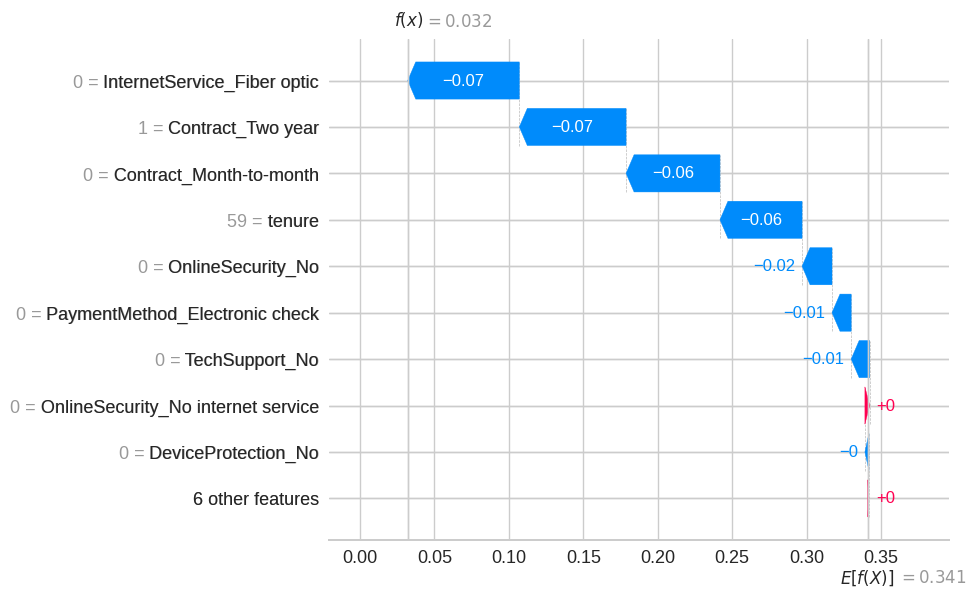

In [61]:
shap.plots.waterfall(shap_values[837])

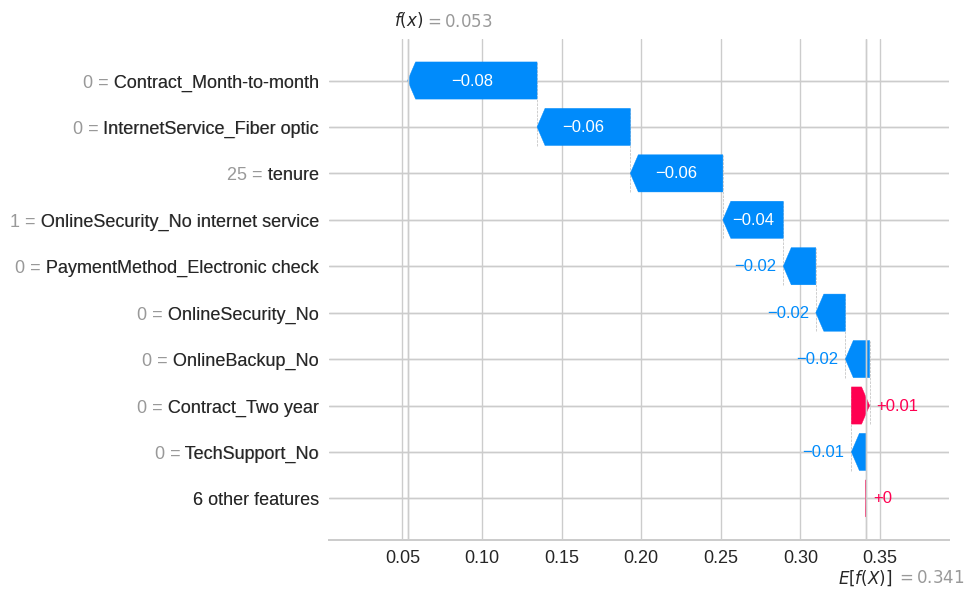

In [62]:
shap.plots.waterfall(shap_values[148])

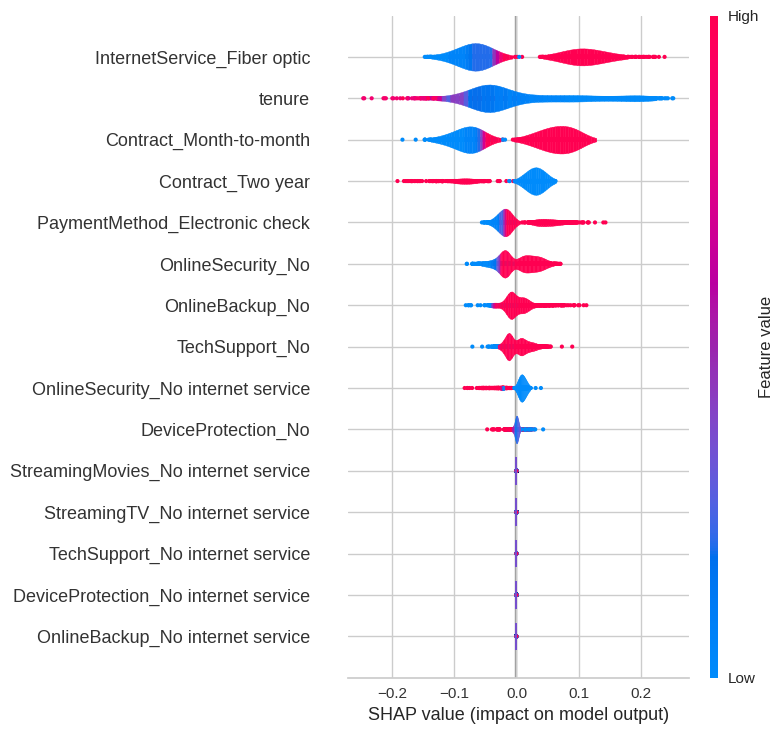

In [64]:
shap.summary_plot(shap_values, plot_type="violin")

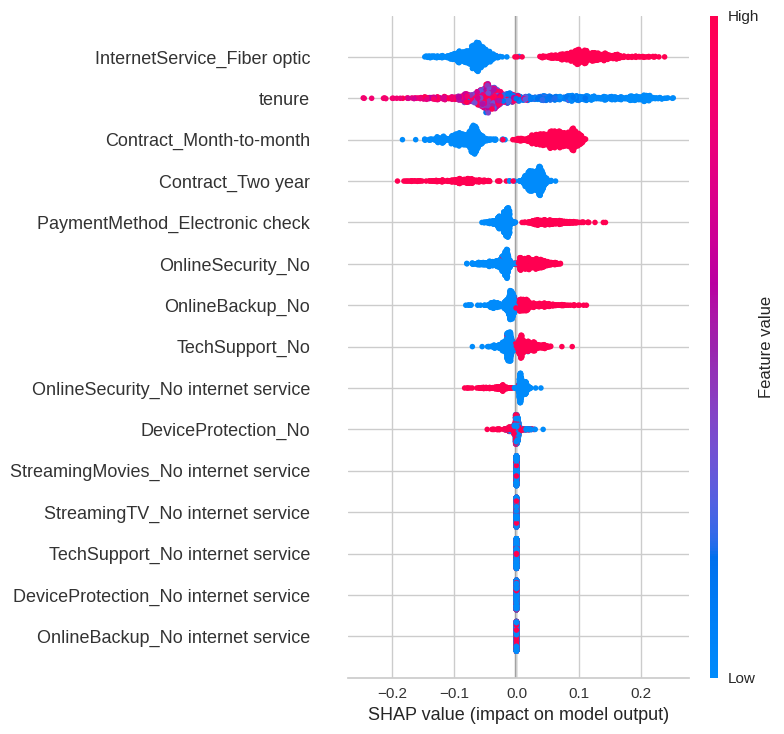

In [63]:
shap.summary_plot(shap_values, X_t_selected)